The following is a simple script that performs an all-sky astrophysical neutrino source search using three years worth of publicly available IceCube muon track data. 

For points in the sky in a pre-determined grid, the script finds the best-fit value of number of neutrinos from a source if a source existed at that given point. If there are any real sources in the set, they would have a best-fit likelihood that would deviate from the background / normal distribution. 

First, we load common libraries and `IceCubeAnalysis`, a custom class that creates the likelihood function and computes the fits for a point that we pass the class. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IceCubeAnalysis

Now that we know all the points on the sky, we create a new `IceCubeAnalysis` instance and load the pre-processed muon track data and background PDF. 

In [19]:
sourcesearch_ = IceCubeAnalysis.SourceSearch("./processed_data/output_icecube_data.npz")
sourcesearch_.load_background("./processed_data/output_icecube_background_count.npz")

A look at the background PDF reveals that it is highest near the horizon, with a sharp cliff at the horizon, and has a higher probability for declinations above $0^\circ$, consistent with more sensitivity down towards the earth instead of up towards less dense atmosphere. The background PDF blows up near to $\pm90^\circ$, but this is not considered in analysis due to a $\pm87^\circ$ cut on sources and points in the sky we are considering. 

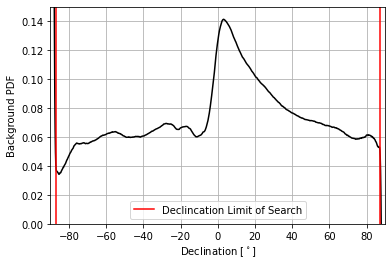

In [20]:
declination_sweep = np.linspace(-90.0, 90.0, 1000)
backgrounds = sourcesearch_.f_B_i(declination_sweep)

plt.plot(declination_sweep, backgrounds, color='black')
plt.axvline(-87.0, color='red')
plt.axvline(87.0, color='red', label="Declincation Limit of Search")
plt.xlabel(r"Declination [$^\circ$]")
plt.ylabel("Background PDF")
plt.xlim(-90.0, 90.0)
plt.ylim(0.0, 0.15)
plt.grid()
plt.legend()

Plotting the IceCube data in a 2D histogram reveals similar shapes to that observed in the background PDF, especially the sharp change at the horizon. In the calculation of the likelihood of neutrino sources, the background PDF and data signal PDFs will cancel to create an even best-fit likelihood map.

Text(0, 0.5, 'Declination [$^\\circ$]')

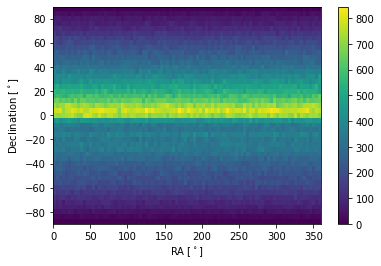

In [21]:
valid_points = np.abs(sourcesearch_.cord_i[:, 1]) < 87.0
plt.hist2d(sourcesearch_.cord_i[valid_points, 0], sourcesearch_.cord_i[valid_points, 1],
           range=((0, 360), (-90, 90)), bins=(360//4, 180//4))
plt.colorbar()
plt.xlim(0.0, 360.0)
plt.ylim(-90.0, 90.0)
plt.xlabel("RA [$^\circ$]")
plt.ylabel("Declination [$^\circ$]")

We prepare the grid on the sky, using a helper function, where we fill calculate best-fit likelihood. The step size on the sky is set by `step_size`. A smaller step size, a more fine grid on the sky and the longer the all-sky map will take to run. A step size of 2 degrees takes ~60 seconds on my machine.

In [22]:
def prepare_skymap_coordinates(step_size):
    """
    Returns the RA and Dec for each point, and a map with the index
    """

    ra_sweep = np.arange(0, 360, step_size)
    dec_sweep = np.arange(-90, 90, step_size)

    ra_len = len(ra_sweep)
    dec_len = len(dec_sweep)

    total_pts = dec_len * ra_len

    index_map = np.zeros((total_pts, 2), dtype='int')

    ras = np.zeros(total_pts)
    decs = np.zeros(total_pts)
    every_pt = np.ones((ra_len, dec_len, 2))

    i_source = 0
    for iX in range(ra_len):
        for iY in range(dec_len):
            index_map[i_source] = [iX, iY]
            ras[i_source] = ra_sweep[iX]
            decs[i_source] = dec_sweep[iY]
            i_source += 1
            every_pt[iX][iY] = [ra_sweep[iX], dec_sweep[iY]]

    return ras, decs, index_map, ra_len, dec_len, every_pt

In [40]:
step_size = 3.0  # Degrees step on the sky

In [41]:
cat_ra, cat_dec, index_map, ra_len, dec_len, every_pt = prepare_skymap_coordinates(step_size)
N_sky_pts = len(cat_ra)
cord_s = np.stack((cat_ra, cat_dec), axis=1)

The fit is performed at each point in the sky using the function `job_submission` in the `IceCubeAnalysis` instance. The function takes the location on the sky (and an integer, used for printouts) to fit for the most likely number of neutrinos associated with a source at that point and returns both the number of neutrinos fit and its likelihood. The fit is computationally intensive. To reduce computing time, I deploy the `multiprocessing` library to distribute the fits to all cores on the computer, `n_cpu`. The next cell takes ~60 seconds on my machine.

In [ ]:
import time
from multiprocessing import Pool
n_cpu = 4

start_time = time.time()
pool = Pool(n_cpu)
args_for_multiprocessing = [(np.array(cord_s[i_source]), i_source) for i_source in range(N_sky_pts)]
parallel_results = pool.starmap(sourcesearch_.job_submission, args_for_multiprocessing)
pool.close()
end_time = time.time()
print("Using parallel, time passed was: \t %f" % (end_time - start_time))

With the big computing done, the result is saved into `parallel_results`. The next cell reformats the output for plotting.

In [32]:
parallel_results_ = [list(t) for t in zip(*parallel_results)]
ns = parallel_results_[0]
del_ln_L = parallel_results_[1]

n_s_map = np.reshape(ns, (ra_len, dec_len))

likelihood_map = np.reshape(del_ln_L, (ra_len, dec_len))
likelihood_map[likelihood_map <= 0.0] = 0.0
sqrt_ts = np.sqrt(2.0 * likelihood_map)
sqrt_ts[np.abs(every_pt[:,:,1]) > 87.0] = 0.0

I fit the distribution of test statistics (related to likelihoods) with a Gaussian to visualize the deviation from background. It is expected that, for a source-free sky, the distribution of test statistics will be equal to statistical fluctuations, a Gaussian distrbution. 

In [33]:
from scipy.optimize import curve_fit
import time

counts, bin_edges = np.histogram(sqrt_ts.flatten(), range=(0, 6), bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# Fit the histogram with a gaussian.
def log_gaus(x, a, b):
    return a + b * x * x

bins_to_fit = counts != 0
popt, pcov = curve_fit(log_gaus, bin_centers[bins_to_fit], np.log(counts[bins_to_fit]))

Plotting the test statistics, the fit, and the residual reveals nothing obviously deviating from statistical fluctuations. 

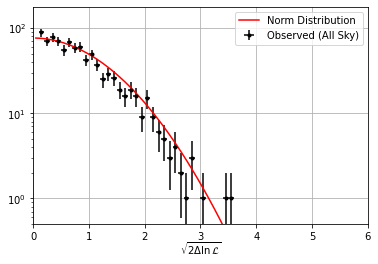

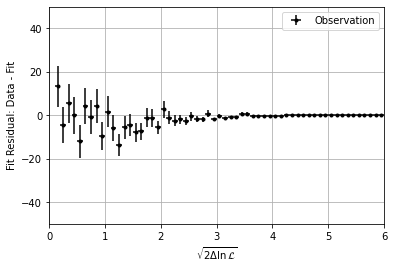

In [34]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.errorbar(bin_centers, counts, xerr=3/len(counts), yerr=np.sqrt(counts),
            color="black", label="Observed (All Sky)", fmt='.')
ax.plot(bin_centers, np.exp(log_gaus(bin_centers, *popt)),
        color='red', label="Norm Distribution")
ax.set_ylim(0.5, 2.0 * counts[1])
ax.set_xlim(0.0, 6.0)
ax.set_xlabel("$\sqrt{2 \Delta \ln \mathcal{L}}$", labelpad=-1)
ax.grid()
ax.legend()

fig, ax = plt.subplots()
residual = counts - np.exp(log_gaus(bin_centers, *popt))
ax.errorbar(bin_centers, residual, xerr=3/len(counts), yerr=np.sqrt(counts),
            color="black", label="Observation", fmt='.')
ax.set_ylim(-50.0, 50.0)
ax.set_xlim(0.0, 6.0)
ax.set_xlabel("$\sqrt{2 \Delta \ln \mathcal{L}}$")
ax.set_ylabel("Fit Residual: Data - Fit")
ax.legend()
ax.grid()

To visualize hot spots, I create a 2D figure of the test statistic using the Aitoff projection. Below is also the definition of the color scheme used in the paper. 

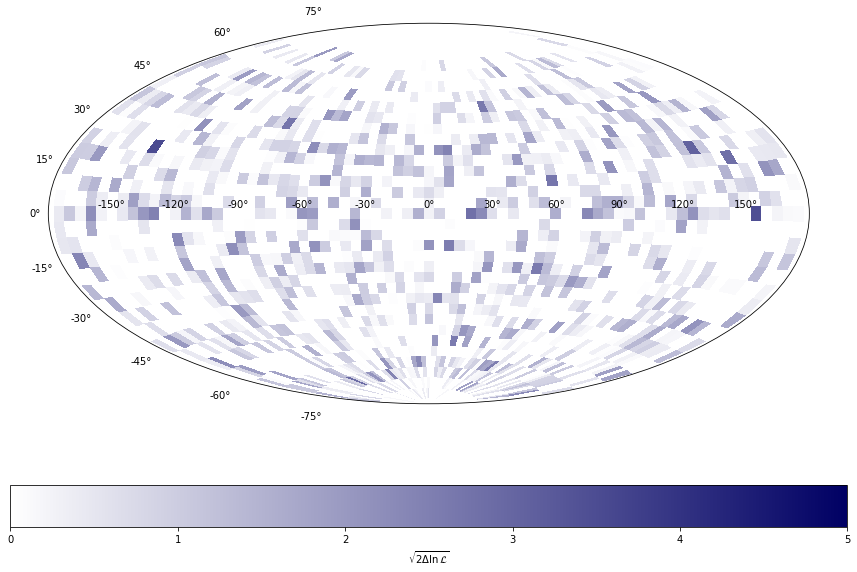

In [35]:
from matplotlib.colors import ListedColormap
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 0/256, N)
vals[:, 1] = np.linspace(1, 0/256, N)
vals[:, 2] = np.linspace(1, 100/256, N)
newcmp = ListedColormap(vals)

plt.figure(figsize=(15,10))
ax = plt.subplot(111, projection="aitoff")
pcolormesh = ax.pcolormesh(np.deg2rad(every_pt[:,:,0])-np.pi,
                           np.deg2rad(every_pt[:,:,1]),
                           sqrt_ts,
                           cmap=newcmp, vmin=0, vmax=5)
cbar = plt.colorbar(pcolormesh, orientation="horizontal")
cbar.set_label("$\sqrt{2 \Delta \ln \mathcal{L}}$")